<summary>Table of Contents</summary>

- [1. Comparison of models](#1-comparison-of-models)
- [2. Sequence length](#2-sequence-length)
- [3. Self-supervised](#3-self-supervised)
- [4. Ablation study](#4-ablation-study)
- [5. TimeLLM](#5-timellm)
- [6. Decomposition](#6-decomposition)

This script summarizes results from all experiments and represents them in plots. On the plots is UK, but in tables is GB. GB here is United Kingdom.

In [ ]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         group_and_reindex_df, \
                         choose_best_model, \
                         calculate_improvement
                         
from utils.plot_final_results import plot_results_models_multiple_countries, \
                                      plot_comparison_for_metrics, \
                                      plot_barplots


: 

# 1. Input length

In [ ]:
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_21_df = read_results_csv('patchtst/patchtst_168_21_patch.csv',
                                   columns_to_extract = ('PatchTST/21', ['RMSE', 'MAE'])
                                   )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

all_df_store = pd.concat([patchtst_21_df, patchtst_df, patchtst_64_df], axis=1)

# Change country codes to country names
level_names = all_df_store.index.names
all_df_store.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df_store.index],
    names=level_names
)
# Scale
scale = 10**2
all_df_scale_store = all_df_store * scale

# With best PatchTST configurations
result_df_unscaled = choose_best_model(all_df_store,
                                       'PatchTST')
result_df = result_df_unscaled * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale_store, decimal_places=2)
styled_df


In [ ]:
best_vs_base = pd.concat([result_df, all_df_scale_store.loc[:, all_df_store.columns.get_level_values('Model') == 'PatchTST/42']], axis=1)
best_vs_base = calculate_improvement(best_vs_base, 
                                      base_mae_model='PatchTST', 
                                      model_to_compare_mae='PatchTST/42',
                                      grouped_by_models=False)
print(f"Average improvement of MAE: {(best_vs_base.loc[best_vs_base['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(best_vs_base.loc[best_vs_base['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

In [ ]:
best_vs_base['mae_improvement'] = best_vs_base['mae_improvement'].apply(lambda x: str(x) + '%' if x != 0 else '--')
best_vs_base['rmse_improvement'] = best_vs_base['rmse_improvement'].apply(lambda x: str(x) + '%' if x != 0 else '--')
best_vs_base.round(2)

In [ ]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_input_length_10_power_2.html'), index=True)

# 2. Comparison of models

In [ ]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )

# Concat all dfs with default PatchTST
all_df = pd.concat([informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale = all_df * scale

# Concat all dfs with best PatchTST - FINAL TABLE
all_df_with_result = pd.concat(
    [result_df, all_df_scale],
    axis=1
)

unscaled_for_plots = all_df_with_result / scale

all_df_with_result.columns.names = ['Model', 'Metrics']

# Highlight the minimum values in bold.
styled_df = style_dataframe(all_df_with_result, decimal_places=2, second_value=True)
styled_df

In [ ]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_baselines_10_power_2.html'), index=True)

In [ ]:
maes = all_df_with_result.loc[:, (slice(None), 'MAE')].droplevel('Metrics', axis=1)
rmses = all_df_with_result.loc[:, (slice(None), 'RMSE')].droplevel('Metrics', axis=1)
(maes - rmses).round(2)

In [ ]:
informer_improvement = all_df_with_result.copy()
informer_improvement = calculate_improvement(informer_improvement, 
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='Informer',
                      grouped_by_models=False).round(2)
informer_improvement

In [ ]:
informer_improvement['mae_improvement'].groupby('Country').mean()

In [ ]:
informer_improvement['rmse_improvement'].groupby('Country').mean()

In [ ]:
print(f"Average improvement of MAE: {(informer_improvement.loc[informer_improvement['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(informer_improvement.loc[informer_improvement['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

In [ ]:
second_best_improvement = all_df_with_result.copy()
second_best_improvement = calculate_improvement(second_best_improvement, 
                      base_mae_model='PatchTST', 
                      grouped_by_models=False).round(2)
second_best_improvement
                                                    

In [ ]:
print(f"Average improvement of MAE: {(second_best_improvement.loc[second_best_improvement['improvement_mae']!=0]['improvement_mae'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(second_best_improvement.loc[second_best_improvement['improvement_rmse']!=0]['improvement_rmse'].mean()).round(2)} %.")

In [ ]:
second_best_improvement['improvement_mae'].groupby('Country').mean()

In [ ]:
second_best_improvement['improvement_rmse'].groupby('Country').mean()

In [ ]:
second_best_improvement['improvement_mae'].groupby('Pred_len').mean()

Create plots.

In [ ]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

In [ ]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

# 3. Self-supervised

In [ ]:
# Read data
self_sup = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    ).sort_index(ascending=True)
self_supervised = self_sup.copy()
# Change country codes to country names
self_supervised.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in self_supervised.index],
    names=level_names
)

all_df = pd.concat([self_supervised, result_df_unscaled], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [ ]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

# 4. Ablation study

# No RevIN

In [ ]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )

patchtst_mix_corr = read_results_csv('patchtst/channel_mixing_new.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('-P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

all_df = pd.concat([result_df_unscaled, all_df], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

In [ ]:
# Calculate difference
models = ['-RevIN', 'CM', '-P']
metrics = ['RMSE', 'MAE']

results = {}
for model in models:
    for metric in metrics:
        results[(model, metric)] = all_df.loc[:, (model, metric)] - all_df.loc[:, ('PatchTST', metric)]

diff_df = pd.DataFrame(results)
level_names = all_df.index.names
diff_df.columns = pd.MultiIndex.from_tuples(diff_df.columns, names=all_df.columns.names)

# Rename for plot
rename_map = {'-RevIN': 'w/o RevIN', 'CM': 'CM', '-P': 'w/o Patching'}
new_columns = diff_df.columns.to_frame(index=False)
new_columns['Model'] = new_columns['Model'].replace(rename_map)
diff_df.columns = pd.MultiIndex.from_frame(new_columns)
diff_df.round(4)

In [ ]:
plot_results_models_multiple_countries(diff_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

In [ ]:
plot_results_models_multiple_countries(diff_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

In [225]:
no_revin.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in no_revin.index],
    names=level_names
)

revin = pd.concat([result_df_unscaled, no_revin], axis=1)

# Scale
revin = revin * scale

revin['rmse_improvement'] = (revin.loc[:, ('-RevIN', 'RMSE')] - (revin.loc[:, ('PatchTST', 'RMSE')]))
revin['mae_improvement'] = (revin.loc[:, ('-RevIN', 'MAE')] - revin.loc[:, ('PatchTST', 'MAE')])
revin.round(2)

Model                   PatchTST        -RevIN        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  14.77   9.52             0.34   
               96          18.61  12.82  19.06  13.06             0.45   
               168         19.27  13.54  19.75  13.73             0.48   
United Kingdom 24          15.65  10.27  16.31  10.95             0.67   
               96          20.02  14.09  20.14  14.31             0.12   
               168         20.62  14.66  21.95  15.56             1.33   
Spain          24           9.87   6.07  13.55   8.41             3.68   
               96          13.49   8.79  17.61  11.43             4.12   
               168         14.21   9.48  18.14  12.12             3.93   
France         24           9.97   5.66  10.48   6.40             0.51   
               96          13.63   8.20  13.92   8.73             0.29   
               168         14.26   8.86  14.65   9.29             0.39   
Italy          24           9.95   5.82  10.42   6.58             0.48   
               96          13.15   7.98  13.37   8.60             0.22   
               168         13.75   8.58  13.75   8.97             0.00   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  0.41  
               96                  0.24  
               168                 0.19  
United Kingdom 24                  0.69  
               96                  0.21  
               168                 0.91  
Spain          24                  2.34  
               96                  2.63  
               168                 2.64  
France         24                  0.74  
               96                  0.53  
               168                 0.43  
Italy          24                  0.76  
               96                  0.62  
               168                 0.39

In [226]:
decimal_places = 2
format_string = f"{{:.{decimal_places}f}}"
styled_df = revin.style.format(format_string)
styled_df.to_html(os.path.join(path, 'no_revin_10_power_2.html'), index=True)

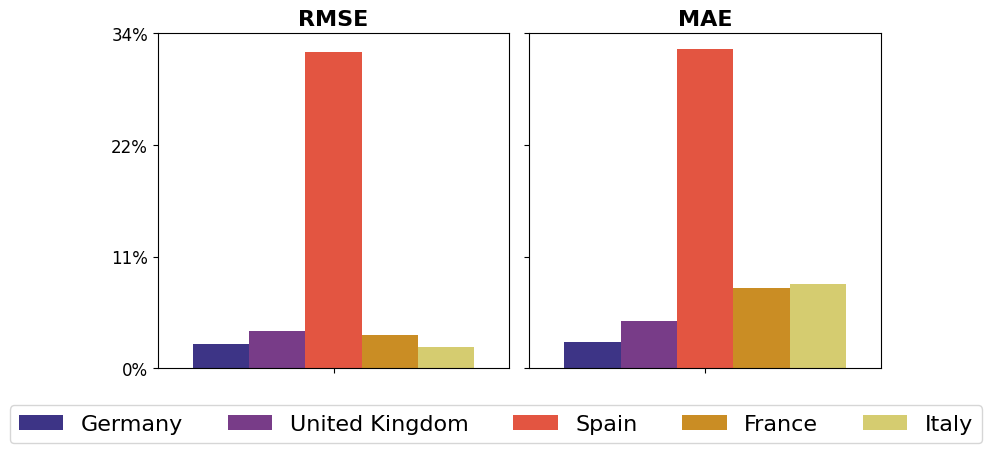

In [227]:
sorting = ['Germany', 'United Kingdom', 'Spain', 'France', 'Italy']

revin_improvement = calculate_improvement(revin, 
                      base_mae_model='-RevIN', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)

mean_mae = revin_improvement['mae_improvement'].groupby('Country').mean().abs().reindex(sorting).to_frame().reset_index()
mean_mae['Metrics'] = 'MAE'
mean_mae.rename(columns={'mae_improvement': 'Value'}, inplace=True)
mean_rmse = revin_improvement['rmse_improvement'].groupby('Country').mean().abs().reindex(sorting).to_frame().reset_index()
mean_rmse['Metrics'] = 'RMSE'
mean_rmse.rename(columns={'rmse_improvement': 'Value'}, inplace=True)
mean_improvements = pd.concat([mean_rmse, mean_mae], axis=0)
plot_barplots(mean_improvements, 'Country', col_name='Metrics', palette='CMRmap', decimal_places=0, percentage=True)

In [228]:
revin.groupby('Country').mean().round(2)

Model          PatchTST        -RevIN        rmse_improvement mae_improvement
Metrics            RMSE    MAE   RMSE    MAE                                 
Country                                                                      
France            12.62   7.58  13.01   8.14            -3.32           -8.12
Germany           17.43  11.82  17.86  12.10            -2.41           -2.58
Italy             12.28   7.46  12.52   8.05            -2.16           -8.45
Spain             12.52   8.11  16.43  10.65           -31.86          -32.12
United Kingdom    18.76  13.01  19.47  13.61            -3.77           -4.79

# Channel-mixing

In [229]:
patchtst_mix_features.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in patchtst_mix_features.index],
    names=level_names
)

patchtst_mix_features = pd.concat([result_df_unscaled, patchtst_mix_features], axis=1)

# Scale
patchtst_mix_features = patchtst_mix_features * scale

patchtst_mix_features['rmse_improvement'] = (patchtst_mix_features.loc[:, ('CM', 'RMSE')] - patchtst_mix_features.loc[:, ('PatchTST', 'RMSE')]) 
patchtst_mix_features['mae_improvement'] = (patchtst_mix_features.loc[:, ('CM', 'MAE')] - patchtst_mix_features.loc[:, ('PatchTST', 'MAE')]) 
patchtst_mix_features.round(2)

Model                   PatchTST            CM        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  15.96  10.60             1.53   
               96          18.61  12.82  19.53  13.84             0.93   
               168         19.27  13.54  20.01  14.28             0.74   
United Kingdom 24          15.65  10.27  16.91  11.75             1.26   
               96          20.02  14.09  20.69  14.71             0.67   
               168         20.62  14.66  21.21  15.20             0.59   
Spain          24           9.87   6.07  10.68   6.92             0.81   
               96          13.49   8.79  14.37   9.65             0.88   
               168         14.21   9.48  15.14  10.32             0.92   
France         24           9.97   5.66  10.49   6.11             0.52   
               96          13.63   8.20  13.83   8.49             0.20   
               168         14.26   8.86  14.13   8.89            -0.13   
Italy          24           9.95   5.82  10.33   6.20             0.38   
               96          13.15   7.98  13.72   8.60             0.57   
               168         13.75   8.58  14.08   9.02             0.33   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  1.50  
               96                  1.02  
               168                 0.74  
United Kingdom 24                  1.48  
               96                  0.62  
               168                 0.55  
Spain          24                  0.85  
               96                  0.86  
               168                 0.85  
France         24                  0.44  
               96                  0.29  
               168                 0.03  
Italy          24                  0.38  
               96                  0.62  
               168                 0.44

In [230]:
decimal_places = 2
format_string = f"{{:.{decimal_places}f}}"
styled_df = patchtst_mix_features.style.format(format_string)
styled_df.to_html(os.path.join(path, 'cm_10_power_2.html'), index=True)

In [231]:
patchtst_mix_corr.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in patchtst_mix_corr.index],
    names=level_names
)

patchtst_mix_corr = pd.concat([result_df_unscaled, patchtst_mix_corr], axis=1)

# Scale
patchtst_mix_corr = patchtst_mix_corr * scale

patchtst_mix_corr['rmse_improvement'] = (patchtst_mix_corr.loc[:, ('CM', 'RMSE')] - patchtst_mix_corr.loc[:, ('PatchTST', 'RMSE')]) 
patchtst_mix_corr['mae_improvement'] = (patchtst_mix_corr.loc[:, ('CM', 'MAE')] - patchtst_mix_corr.loc[:, ('PatchTST', 'MAE')]) 
patchtst_mix_corr.round(2)

Model                   PatchTST            CM        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  15.29  10.06             0.86   
               96          18.61  12.82  19.53  13.84             0.93   
               168         19.27  13.54  20.01  14.28             0.74   
United Kingdom 24          15.65  10.27  16.30  10.94             0.65   
               96          20.02  14.09  20.69  14.71             0.67   
               168         20.62  14.66  21.21  15.20             0.59   
Spain          24           9.87   6.07  10.68   6.92             0.81   
               96          13.49   8.79  14.37   9.65             0.88   
               168         14.21   9.48  15.14  10.32             0.92   
France         24           9.97   5.66  10.49   6.11             0.52   
               96          13.63   8.20  13.83   8.49             0.20   
               168         14.26   8.86  14.13   8.89            -0.13   
Italy          24           9.95   5.82  10.33   6.20             0.38   
               96          13.15   7.98  13.72   8.60             0.57   
               168         13.75   8.58  14.08   9.02             0.33   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  0.95  
               96                  1.02  
               168                 0.74  
United Kingdom 24                  0.68  
               96                  0.62  
               168                 0.55  
Spain          24                  0.85  
               96                  0.86  
               168                 0.85  
France         24                  0.44  
               96                  0.29  
               168                 0.03  
Italy          24                  0.38  
               96                  0.62  
               168                 0.44

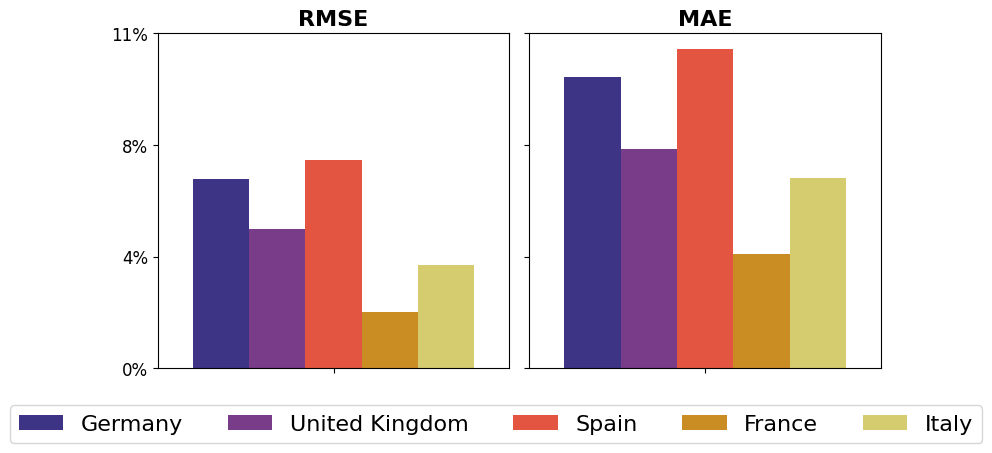

In [232]:
cm_improvement = calculate_improvement(patchtst_mix_features, 
                      base_mae_model='CM', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)

mean_mae = cm_improvement['mae_improvement'].groupby('Country').mean().abs().reindex(sorting).to_frame().reset_index()
mean_mae['Metrics'] = 'MAE'
mean_mae.rename(columns={'mae_improvement': 'Value'}, inplace=True)
mean_rmse = cm_improvement['rmse_improvement'].groupby('Country').mean().abs().reindex(sorting).to_frame().reset_index()
mean_rmse['Metrics'] = 'RMSE'
mean_rmse.rename(columns={'rmse_improvement': 'Value'}, inplace=True)
mean_improvements = pd.concat([mean_rmse, mean_mae], axis=0)
plot_barplots(mean_improvements, 'Country', col_name='Metrics', palette='CMRmap', decimal_places=0, percentage=True)

# No patching

In [233]:
no_patch.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in no_patch.index],
    names=level_names
)

no_patch = pd.concat([result_df_unscaled, no_patch], axis=1)

# Scale
no_patch = no_patch * scale

no_patch['rmse_improvement'] = (no_patch.loc[:, ('-P', 'RMSE')] - no_patch.loc[:, ('PatchTST', 'RMSE')]) 
no_patch['mae_improvement'] = (no_patch.loc[:, ('-P', 'MAE')] - no_patch.loc[:, ('PatchTST', 'MAE')]) 
no_patch.round(2)

Model                   PatchTST            -P        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  14.80   9.50             0.37   
               96          18.61  12.82  18.82  13.17             0.22   
               168         19.27  13.54  19.39  13.65             0.12   
United Kingdom 24          15.65  10.27  16.04  10.57             0.39   
               96          20.02  14.09  20.07  14.15             0.06   
               168         20.62  14.66  20.75  14.70             0.13   
Spain          24           9.87   6.07  10.27   6.48             0.41   
               96          13.49   8.79  13.88   9.23             0.39   
               168         14.21   9.48  14.63   9.81             0.42   
France         24           9.97   5.66  10.42   5.99             0.45   
               96          13.63   8.20  14.15   8.58             0.52   
               168         14.26   8.86  14.83   9.11             0.57   
Italy          24           9.95   5.82  10.12   6.07             0.18   
               96          13.15   7.98  13.53   8.31             0.38   
               168         13.75   8.58  13.94   8.77             0.19   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                  0.39  
               96                  0.35  
               168                 0.11  
United Kingdom 24                  0.30  
               96                  0.06  
               168                 0.04  
Spain          24                  0.41  
               96                  0.43  
               168                 0.33  
France         24                  0.33  
               96                  0.37  
               168                 0.25  
Italy          24                  0.25  
               96                  0.34  
               168                 0.19

In [234]:
decimal_places = 2
format_string = f"{{:.{decimal_places}f}}"
styled_df = no_patch.style.format(format_string)
styled_df.to_html(os.path.join(path, 'no_patch_10_power_2.html'), index=True)

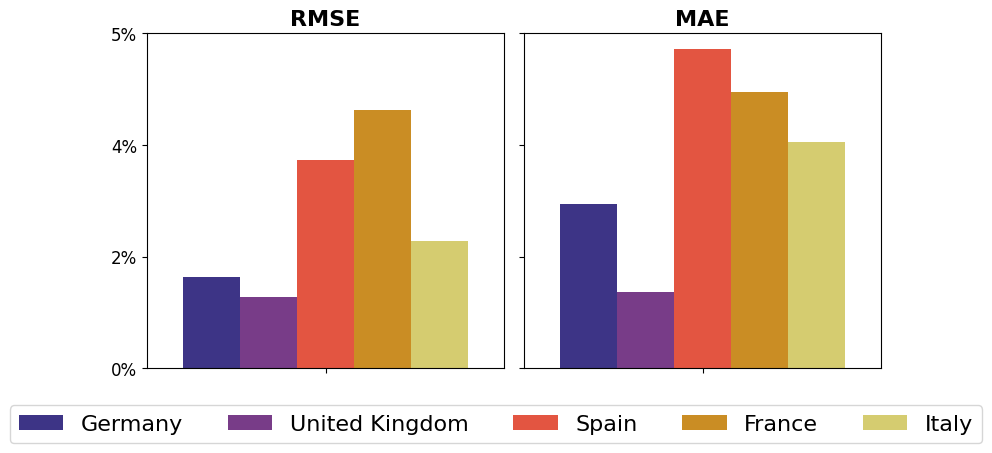

In [235]:
patch_improvement = calculate_improvement(no_patch, 
                      base_mae_model='-P', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)

mean_mae = patch_improvement['mae_improvement'].groupby('Country').mean().abs().reindex(sorting).to_frame().reset_index()
mean_mae['Metrics'] = 'MAE'
mean_mae.rename(columns={'mae_improvement': 'Value'}, inplace=True)
mean_rmse = patch_improvement['rmse_improvement'].groupby('Country').mean().abs().reindex(sorting).to_frame().reset_index()
mean_rmse['Metrics'] = 'RMSE'
mean_rmse.rename(columns={'rmse_improvement': 'Value'}, inplace=True)
mean_improvements = pd.concat([mean_rmse, mean_mae], axis=0)
plot_barplots(mean_improvements, 'Country', col_name='Metrics', palette='CMRmap', decimal_places=0, percentage=True)

In [239]:
# Remove duplicate entries in the 'Model' level if they are redundant
unique_models = all_df.columns.get_level_values('Model').unique()

rename_map = {'PatchTST': 'PatchTST', '-RevIN': 'w/o RevIN', 'CM': 'CM', '-P': 'w/o Patching'}
renamed_models = unique_models.map(lambda x: rename_map.get(x, x))

all_df.columns = all_df.columns.set_levels(
    renamed_models, 
    level='Model'
)


In [240]:
all_df

Model                    PatchTST           w/o RevIN                  CM  \
Metrics                      RMSE       MAE      RMSE       MAE      RMSE   
Country        Pred_len                                                     
Germany        24        0.144288  0.091084  0.147654  0.095209  0.159581   
               96        0.186050  0.128178  0.190579  0.130551  0.195303   
               168       0.192703  0.135422  0.197468  0.137282  0.200066   
United Kingdom 24        0.156486  0.102693  0.163141  0.109548  0.169059   
               96        0.200196  0.140945  0.201405  0.143074  0.206866   
               168       0.206196  0.146580  0.219545  0.155647  0.212143   
Spain          24        0.098651  0.060730  0.135463  0.084121  0.106798   
               96        0.134874  0.087946  0.176115  0.114289  0.143719   
               168       0.142106  0.094763  0.181436  0.121204  0.151351   
France         24        0.099705  0.056644  0.104767  0.064045  0.104904   
               96        0.136293  0.082043  0.139216  0.087315  0.138270   
               168       0.142563  0.088618  0.146450  0.092919  0.141266   
Italy          24        0.099454  0.058198  0.104222  0.065782  0.103280   
               96        0.131510  0.079750  0.133697  0.085971  0.137174   
               168       0.137492  0.085801  0.137539  0.089678  0.140822   

Model                             w/o Patching            
Metrics                       MAE         RMSE       MAE  
Country        Pred_len                                   
Germany        24        0.106048     0.147992  0.095001  
               96        0.138427     0.188209  0.131721  
               168       0.142797     0.193885  0.136488  
United Kingdom 24        0.117454     0.160396  0.105714  
               96        0.147130     0.200746  0.141504  
               168       0.152048     0.207493  0.147029  
Spain          24        0.069194     0.102723  0.064822  
               96        0.096530     0.138756  0.092279  
               168       0.103249     0.146265  0.098105  
France         24        0.061053     0.104194  0.059935  
               96        0.084933     0.141475  0.085759  
               168       0.088933     0.148310  0.091145  
Italy          24        0.061997     0.101234  0.060741  
               96        0.085988     0.135286  0.083104  
               168       0.090156     0.139423  0.087690

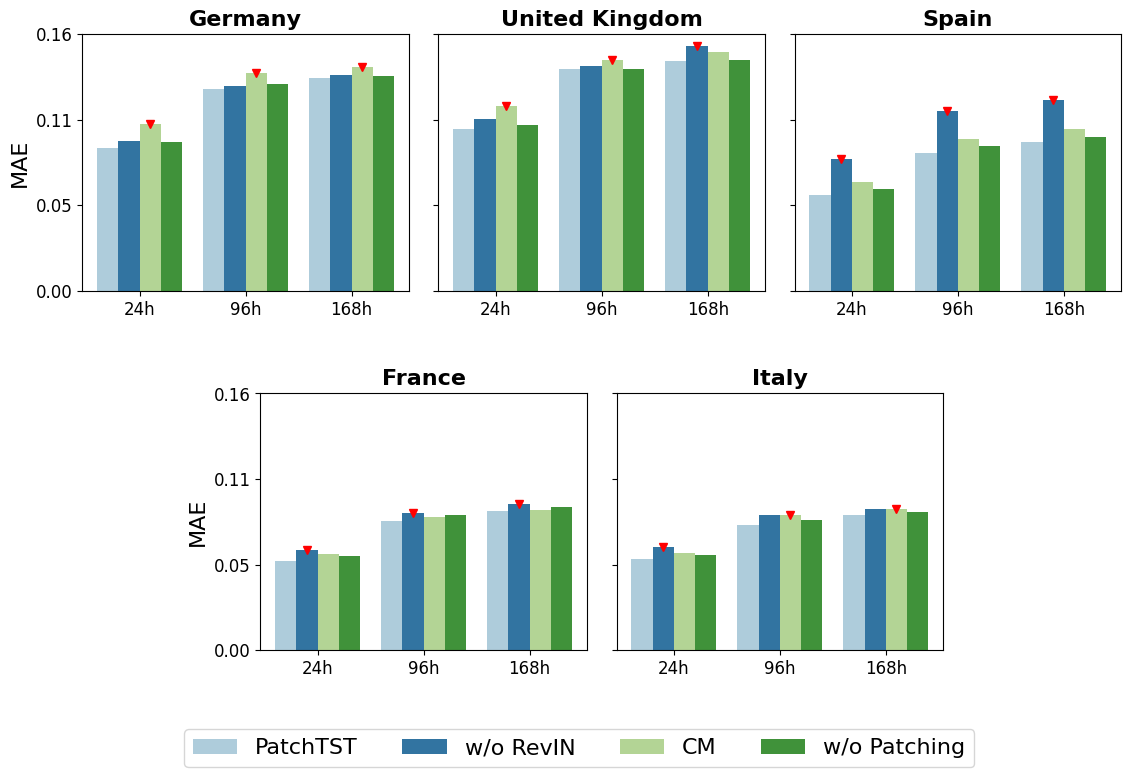

In [241]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

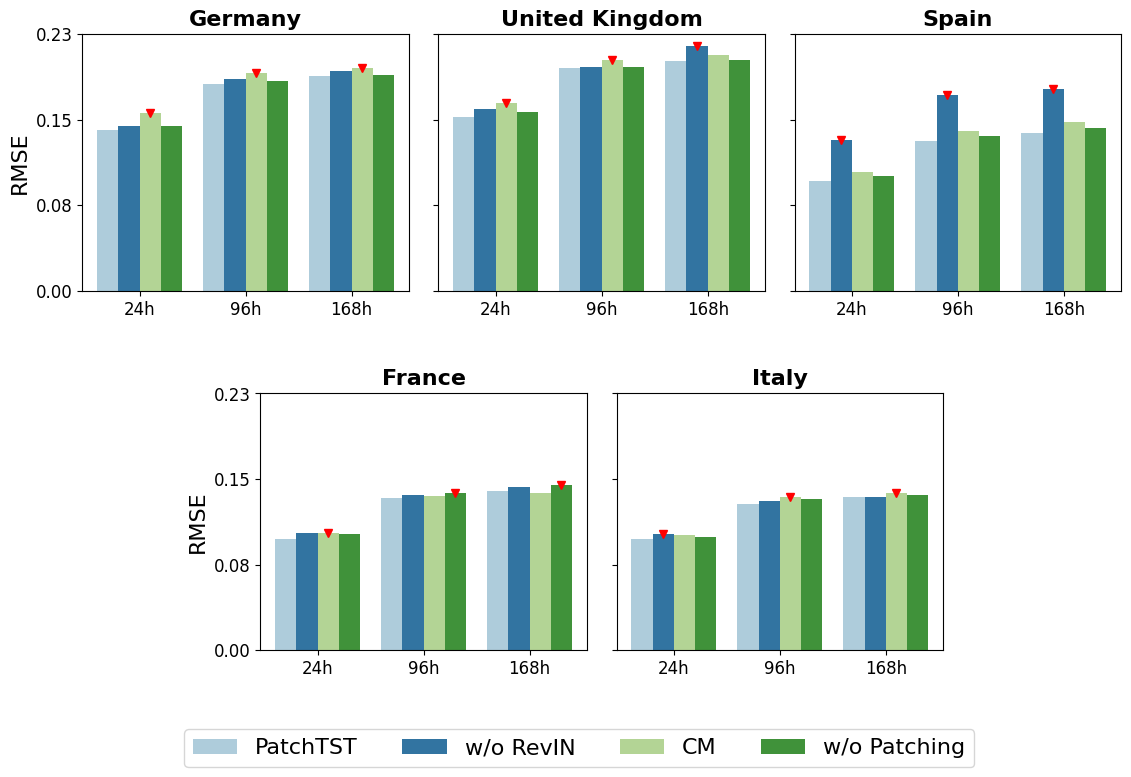

In [242]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

In [72]:
styled_df.to_html(os.path.join(path, 'ablation_10_power_2.html'), index=True)

# 5. TimeLLM

In [73]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM', ['RMSE', 'MAE'])
                              )

#all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
timellm_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in timellm_df.index],
    names=level_names
)

timellm_df_scale = timellm_df * scale

df_with_timellm = pd.concat([timellm_df_scale, result_df], axis=1)
styled_df = style_dataframe(df_with_timellm, decimal_places=2)
styled_df


In [74]:
all_df_with_result

Model                     PatchTST              Informer             \
Metrics                       RMSE        MAE       RMSE        MAE   
Country        Pred_len                                               
Germany        24        14.428827   9.108440  15.967456  10.630149   
               96        18.605006  12.817755  20.386988  14.678194   
               168       19.270323  13.542156  21.424752  15.394257   
United Kingdom 24        15.648589  10.269263  17.643772  12.031002   
               96        20.019588  14.094529  22.498161  16.008191   
               168       20.619559  14.658014  25.912988  18.294008   
Spain          24         9.865136   6.073029  17.424941  10.449938   
               96        13.487436   8.794557  21.236445  13.736703   
               168       14.210615   9.476299  21.376996  14.075865   
France         24         9.970529   5.664379  11.710318   7.169972   
               96        13.629286   8.204299  14.804927   9.203359   
               168       14.256333   8.861789  15.137461   9.534455   
Italy          24         9.945400   5.819772  10.667097   6.598817   
               96        13.150957   7.975036  13.695967   9.164635   
               168       13.749237   8.580074  14.525099   9.748273   

Model                     (S)ARIMA            Persistence             
Metrics                       RMSE        MAE        RMSE        MAE  
Country        Pred_len                                               
Germany        24        11.152702   9.319427   19.614000  13.872000  
               96        20.279962  16.490913   26.138000  19.692000  
               168       22.785564  18.514859   23.390000  17.008000  
United Kingdom 24        14.408275  12.014517   19.894000  14.450000  
               96        21.527349  17.685590   25.542000  19.418000  
               168       22.669082  18.283188   24.692000  18.556000  
Spain          24         9.677071   7.889427   14.060000   9.433333  
               96        14.170089  11.218577   19.666667  13.916667  
               168       17.610734  13.585881   17.736667  12.380000  
France         24         7.602105   6.056851   12.240000   8.003333  
               96        12.541838   9.806465   17.823333  12.503333  
               168       14.891068  11.498020   16.286667  10.806667  
Italy          24         8.643231   6.976903   14.396667   9.663333  
               96        13.123777  10.333491   19.710000  14.096667  
               168       16.571058  12.759511   15.686667  10.916667

In [75]:
# Highlight the minimum values in bold.
all_df_with_timellm = pd.concat([timellm_df_scale, all_df_with_result], axis=1)
styled_df = style_dataframe(all_df_with_timellm, decimal_places=2, second_value=True)
styled_df

In [76]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'timellm_10_power_2.html'), index=True)

In [64]:
# DE, UK pred_len=24: seq_len=336,
# FR, pred_len=24: seq_len=168
# ES, IT (all pred_len): seq_len=168
# DE, UK, FR pred_len=96, pred_len=168: seq_len=512
# OR CHOOSE FOR FRANCE 96 168???? (lowest MAE)


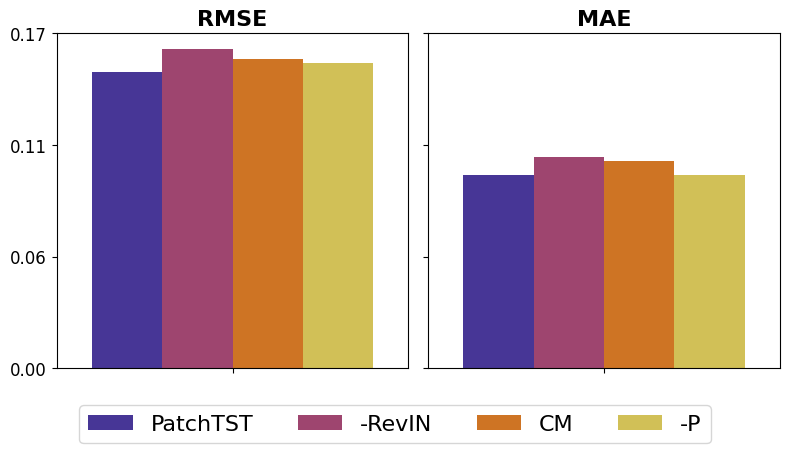

In [65]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [66]:
styled_df.to_html(os.path.join(path, 'timellm_512_10_power_2.html'), index=True)

In [67]:
all_df = pd.concat([timellm_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [68]:
all_df = pd.concat([timellm_df_336, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [69]:
all_df = pd.concat([timellm_df_336, timellm_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

# 6. Decomposition

In [70]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

#all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
decomposition_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in decomposition_df.index],
    names=level_names
)

# Scale
decomposition_df_scale = decomposition_df * scale
all_df = pd.concat([result_df, decomposition_df_scale], axis=1)

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df, decimal_places=2)
styled_df